In [1]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import seaborn as sns
from datetime import datetime, timedelta
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image


In [2]:
def create_custom_reds_colormap():
    # Get the 'Reds' colormap
    reds = plt.cm.get_cmap('Reds', 256)
    
    # Convert the 'Reds' colormap to a numpy array with 256 colors
    reds_colors = reds(np.linspace(0, 1, 256))
    
    # Replace the first 10% of the colormap with white (you can adjust this percentage)
    reds_colors[:2, :] = [1, 1, 1, 1]  # Set the first 25 colors to white (RGBA = [1,1,1,1])
    
    # Create a new colormap using these colors
    custom_reds = LinearSegmentedColormap.from_list('custom_reds', reds_colors)
    
    return custom_reds

# ------------------------------------------------------------------------------------------------------------------ #

def create_custom_jet_colormap():
    # Get the 'jet' colormap
    jet = plt.cm.get_cmap('jet', 256)
    
    # Convert the 'jet' colormap to a numpy array with 256 colors
    jet_colors = jet(np.linspace(0, 1, 256))
    
    # Replace the first 10% of the colormap with white (you can adjust this percentage)
    jet_colors[:1, :] = [1, 1, 1, 1]  # Set the first 25 colors to white (RGBA = [1,1,1,1])
    
    # Create a new colormap using these colors
    custom_jet = LinearSegmentedColormap.from_list('custom_jet', jet_colors)
    
    return custom_jet

# ------------------------------------------------------------------------------------------------------------------ #

def find_csv_files(directory, pattern="grid_1m.csv"):
    """
    Traverse the given directory and find all CSV files that match the pattern.
    Return a sorted list of full file paths based on the dates in the filenames.
    """
    csv_files = []
    
    # Regex pattern to extract date from the filename
    date_pattern = re.compile(r"(\d{8})")  # Looks for an 8-digit date (YYYYMMDD)

    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(pattern):
                # Get the full path to the file
                full_path = os.path.join(root, file)
                
                # Extract the date from the filename
                match = date_pattern.search(file)
                if match:
                    date_str = match.group(1)  # Extract the first matched date
                    csv_files.append((full_path, date_str))
    
    # Sort the list of tuples (path, date) based on the date string
    csv_files.sort(key=lambda x: x[1])  # Sort by the date part
    
    # Return only the paths, now sorted by date
    return [file[0] for file in csv_files]

# ------------------------------------------------------------------------------------------------------------------ # 

def load_csv_to_numpy(file_list):
    """
    Given a list of CSV file paths, load them into a 3D NumPy array, ignoring row and column labels.
    Each CSV is expected to have the same dimensions, but row and column labels should be ignored.
    
    Parameters:
    file_list (list of str): List of file paths to the CSV files.
    
    Returns:
    numpy.ndarray: A 3D NumPy array where each CSV is a 2D grid.
    """
    grid_list = []
    
    for file in file_list:
        # Load the CSV file into a pandas DataFrame
        # We skip the first row (column labels) and treat the first column as row labels (index_col=0)
        df = pd.read_csv(file, index_col=0, header=0)
        
        # Convert the DataFrame to a NumPy array and append to the list
        grid_list.append(df.values)
    
    # Stack all the 2D grids into a 3D NumPy array
    grid_3d = np.stack(grid_list, axis=0)
    
    return grid_3d

# ------------------------------------------------------------------------------------------------------------------ # 

def matlab_datenum(dt):
    """
    Convert a Python datetime object to MATLAB datenum.
    MATLAB's datenum starts from year 0000, while Python's datetime starts from 1970.
    We adjust for this by adding the number of days from year 0000 to 1970.
    """
    matlab_origin = datetime(1, 1, 1)
    python_origin = datetime(1970, 1, 1)
    diff = python_origin - matlab_origin
    return (dt - python_origin).total_seconds() / 86400.0 + 719529.0

# ------------------------------------------------------------------------------------------------------------------ # 

def extract_dates_from_filename(filename, all=False):
    """
    Extract the two dates from the filename in the format YYYYMMDD, convert to Python datetime, 
    and return the midpoint of the two dates as a MATLAB datenum.
    """
    # Regular expression to find two dates in the format YYYYMMDD
    date_pattern = re.compile(r"(\d{8})")
    dates = date_pattern.findall(filename)
    
    if len(dates) < 2:
        raise ValueError(f"Filename {filename} does not contain two valid dates.")
    
    # Convert the two extracted dates to datetime objects
    date1 = datetime.strptime(dates[0], "%Y%m%d")
    date2 = datetime.strptime(dates[1], "%Y%m%d")
    
    # Find the midpoint between the two dates
    midpoint = date1 + (date2 - date1) / 2
    
    # Convert the midpoint to MATLAB datenum
    midpoint_matlab_datenum = matlab_datenum(midpoint)
    date1 = matlab_datenum(date1)
    date2 = matlab_datenum(date2)
    
    if all:
        return date1, date2, midpoint_matlab_datenum
    else:
        return midpoint_matlab_datenum

# ------------------------------------------------------------------------------------------------------------------ # 

def all_data_to_mat(grid_list, cluster_list, matout):
    """
    Given a list of CSV file paths, load them into a 3D NumPy array and save a .mat file.
    Each CSV is expected to have the same dimensions, and date information is extracted 
    from the filenames, converted to MATLAB datenums, and added to the .mat file.
    
    Parameters:
    grid_list (list of str): List of file paths to the CSV files for volume grid.
    cluster_list (list of str): List of file paths to the CSV files for cluster grid.
    matout (str): The output path for the .mat file.
    
    Returns:
    numpy.ndarray: A 3D NumPy array where each CSV is a 2D grid.
    """
    volume_grid_list = []
    dates = []  # Store dates as a 3xN matrix
    cluster_grid_list = []

    # Process the volume grid CSVs
    for file in grid_list:
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file, header=0, index_col=0)
        
        # Convert the DataFrame to a NumPy array and append to the list
        volume_grid_list.append(df.values)
        
        # Extract the start, midpoint, and end dates (assumed datetime objects)
        start_date, midpoint_date, end_date = extract_dates_from_filename(file, all=True)
        
        # Convert each datetime to MATLAB datenum format using the provided matlab_datenum function
        dates.append([start_date, midpoint_date, end_date])

        if file == grid_list[0]:
            polygons = np.arange(1, df.shape[0] + 1)

    # Stack all the 2D grids into a 3D NumPy array with shape (Time, Y, X)
    volume_grid = np.stack(volume_grid_list, axis=0)

    # Transpose to (Y, X, Time)
    volume_grid = np.transpose(volume_grid, (1, 2, 0))

    # Process the cluster grid CSVs
    for file in cluster_list:
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file, header=0, index_col=3)
        
        # Convert the DataFrame to a NumPy array and append to the list
        cluster_grid_list.append(df.values)
    
    # Stack all the 2D grids into a 3D NumPy array with shape (Time, Y, X)
    cluster_grid = np.stack(cluster_grid_list, axis=0)

    # Transpose to (Y, X, Time)
    cluster_grid = np.transpose(cluster_grid, (1, 2, 0))

    # Get the z bins
    if 'grid_1m' in grid_list[0]:
        z_bins = np.arange(0, 30, 1)
    else:
        z_bins = np.arange(0, 30, 0.1)

    # Convert the dates list to a 3xN NumPy array where N is the number of files
    dates_array = np.array(dates).T  # Transpose to ensure 3xN structure

    # Save the 3D arrays and dates to a .mat file
    scipy.io.savemat(matout, {
        'volume_grid': volume_grid, 
        'cluster_grid': cluster_grid,
        'dates': dates_array,  # Ensure dates are in MATLAB datenum format
        'z_bins': z_bins,
        'polygons': polygons
    })
    
    return volume_grid, cluster_grid, dates_array, z_bins

# ------------------------------------------------------------------------------------------------------------------ # 

def plot_summed_grid(grid_3d_array, vmax, subset=None):
    """
    Plot the 2D sum of the 3D grid data.
    - Summing across the first dimension (time dimension).
    - Switch X and Y axes by transposing the summed grid.
    - Handle NaN values by setting them to white in the plot.
    
    Parameters:
    grid_3d_array (numpy.ndarray): A 3D NumPy array of shape (time_steps, n, m)
    """
    # Sum across the first dimension (axis=0), collapsing the time dimension
    summed_grid = np.nansum(grid_3d_array, axis=0)
    
    # Transpose to switch the x and y axes
    summed_grid = summed_grid.T  # Switches the 2nd and 3rd dimensions (X and Y)
    
    # Define a colormap that handles NaN values (set NaNs to white)
    cmap = create_custom_jet_colormap()
    cmap.set_bad(color='white')  # Set color for NaN values
    
    # Create a masked array where NaN values are masked
    masked_summed_grid = np.ma.masked_invalid(summed_grid)
    
    # Create the figure
    plt.figure(figsize=(20, 6))
    
    # Plot the result using imshow, with the colormap that handles NaN values
    cax = plt.imshow(masked_summed_grid, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax=vmax)
    
    # Adding labels and title
    plt.colorbar(cax, label='Summed Value')
    plt.xlabel('Alongshore Polygon')
    plt.ylabel('Height (m)')
    plt.title('Cumulative Erosion', fontsize=16)

    # Convert y-axis units from 10 cm to meters
    yticks = plt.gca().get_yticks()  # Get current y-tick positions in 10 cm chunks
    plt.gca().set_yticks(yticks)  # Keep the same tick positions
    plt.gca().set_yticklabels([f'{int(tick / 10)}' for tick in yticks])  # Convert from cm to meters
    
    # Invert the x-axis
    plt.gca().invert_xaxis()
    
    # Apply subset if provided
    if subset:
        plt.xlim(subset[0], subset[1])

    plt.ylim(0, 280)

    # Show the plot
    plt.show()


# ------------------------------------------------------------------------------------------------------------------ # 

def plot_heatmap_grid(grid_3d, file_list, vmax, res):
    """
    Creates a heatmap of erosion over time using seaborn heatmap, with surveys mapped to an evenly spaced time grid.
    The X-axis will be visually evenly spaced but represent real survey intervals.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D array of shape (time_steps, alongshore_length, depth).
    file_list (list of str): List of file paths or filenames (used for extracting dates).
    """
    # Extract the shape of the 3D grid
    time_steps, alongshore_length, depth_bins = grid_3d.shape

    # Regular expression to extract the date from filenames (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    date_labels = []

    for i, file in enumerate(file_list):
        # Extract the date from the filename
        match = date_pattern.search(file)
        date_str = match.group(1) if match else f"Survey {i+1}"
        date_labels.append(date_str)

    # Convert date strings (YYYYMMDD) to datetime objects
    date_objects = [datetime.strptime(date, "%Y%m%d") for date in date_labels]

    # Create relative time in days from the first survey
    first_date = date_objects[0]
    relative_days = np.array([(date - first_date).days for date in date_objects])

    # Generate an evenly spaced X-axis for visual representation (equal time spacing)
    evenly_spaced_time = np.linspace(0, max(relative_days), time_steps)

    # Map the grid_3d data to an evenly spaced grid
    evenly_spaced_grid = np.zeros((time_steps, alongshore_length, depth_bins))
    for i, rel_day in enumerate(relative_days):
        # Place the survey data on the evenly spaced grid based on relative days
        time_idx = np.argmin(np.abs(evenly_spaced_time - rel_day))
        evenly_spaced_grid[time_idx] = grid_3d[i]

    # Sum over depth for each time step and alongshore location
    sum_grid = np.nansum(evenly_spaced_grid, axis=2)*res  # Sum over depth (3rd dimension)

    # Plot the heatmap using the evenly spaced X-axis
    plt.figure(figsize=(12, 6))
    sns.heatmap(sum_grid.T, cmap=create_custom_reds_colormap(), cbar_kws={'label': 'Volume (m³)'}, mask=np.isnan(sum_grid.T), vmin=0, vmax=vmax)

    # Label axes for the heatmap
    plt.xlabel('Time')
    plt.ylabel('Alongshore Location (m)')
    plt.gca().invert_yaxis()

    # Set X-tick labels to display actual years on the evenly spaced time grid
    min_year = date_objects[0].year
    max_year = date_objects[-1].year
    january_1st_dates = [datetime(year, 1, 1) for year in range(min_year, max_year + 1)]

    # Find the index of each January 1st in the relative time array and plot those years
    january_1st_indices = [(jan1 - first_date).days for jan1 in january_1st_dates]
    evenly_spaced_jan1st_indices = [np.argmin(np.abs(evenly_spaced_time - idx)) for idx in january_1st_indices]

    # Set the X-tick labels at regular intervals on the evenly spaced grid
    plt.xticks(evenly_spaced_jan1st_indices, [jan1.year for jan1 in january_1st_dates], rotation=45, ha="right")

    # Set Y-tick labels to 0, 500, 1000, 1500, 2000, 2250
    plt.yticks([0, 500, 1000, 1500, 2000, 2250], labels=[0, 500, 1000, 1500, 2000, 2250])

    # Show the heatmap
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ # 

def cum_erosion_curve(grid_3d, grid_files, plotAdam=False, res=.1):
    """
    Plot the cumulative erosion curve for the given grid data.
    The cumulative erosion is calculated by summing the grid data over all alongshore locations.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D grid data of shape (time_steps, alongshore_length, depth).
    grid_files (list of str): List of filenames for the grid data.
    plotAdam (bool): If True, plot Adam's dataset on the same plot, also as cumulative erosion.
    """
    # Extract dates from grid_files using regular expression (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    dates = []
    
    for file in grid_files:
        match = date_pattern.search(file)
        if match:
            date_str = match.group(1)
            dates.append(datetime.strptime(date_str, "%Y%m%d"))

    # Create an evenly spaced time array between the first and last date
    first_date = min(dates)
    last_date = max(dates)
    total_days = (last_date - first_date).days
    time_array = np.array([(date - first_date).days for date in dates])  # Relative time in days from the first date

    # Sum the grid along the alongshore and depth axes
    erosion_per_time_step = np.nansum(grid_3d*res, axis=(1, 2))  # Sum over alongshore and depth axes

    # Calculate cumulative erosion
    cumulative_erosion = np.cumsum(erosion_per_time_step)

    # Plot cumulative erosion over time
    plt.figure(figsize=(12, 4))
    plt.plot(time_array, cumulative_erosion, marker='D', label='Cumulative Erosion')

    # Formatting plot
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Cumulative Erosion (m³)', fontsize=15)
    plt.title('Cumulative Erosion Over Time', fontsize=15)
    plt.grid(True)

    # Generate January 1st of each year between the first and last date
    min_year = first_date.year
    max_year = last_date.year
    january_1st_dates = [datetime(year, 1, 1) for year in range(min_year, max_year + 1)]

    # Convert January 1st dates to the same relative time format
    january_1st_time_array = [(jan1 - first_date).days for jan1 in january_1st_dates]

    # Plot Adam's data if plotAdam is True
    if plotAdam:
        data2021 = pd.read_excel('/Users/cjmack/Documents/Papers/Cliffs/Scratch/1-s2.0-S0169555X20305183-mmc1.xlsx')
        year = data2021.iloc[1:, 1]
        month = data2021.iloc[1:, 2]
        day = data2021.iloc[1:, 3]  
        
        # Combine them all as one date
        date = pd.to_datetime(year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2), format='%Y%m%d')
        data2021['date'] = date

        # Convert Adam's dates to relative time (days since the first_date)
        adam_time_array = np.array([(d - first_date).days for d in data2021['date']])

        # Compute cumulative sum for Adam's data (Negative Change in m³)
        cumulative_adam = np.cumsum(np.abs(data2021['Negative Change (m^3)'].iloc[1:]))

        # Plot Adam's cumulative data
        plt.plot(adam_time_array[1:], cumulative_adam, marker='D', color='black', label="Young 2021")

    # Set X-ticks to only show January 1st of each year
    plt.xticks(ticks=january_1st_time_array, labels=[jan1.year for jan1 in january_1st_dates], rotation=45, ha="right")

    # Add legend to the plot
    plt.legend()

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ # 

def get_cluster_volumes(grid_3d, clusters_3d, grid_files, cluster_files, res=1):
    """
    Calculate the total volume of each cluster in each time step and store the data in a dataframe.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D array of volume measurements (time_steps, alongshore_length, depth).
    clusters_3d (numpy.ndarray): 3D array of cluster IDs (time_steps, alongshore_length, depth).
    grid_files (list of str): List of filenames for the grid data (used to extract dates).
    res (int): Resolution of the grid (optional, default is 1).
    
    Returns:
    pd.DataFrame: A dataframe with columns: start date, end date, midpoint date, volume, centroid indices, and cluster ID.
    """
    # Regular expression to extract two dates from filenames (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")

    # Create a list to store the results
    results = []

    for time_step in range(grid_3d.shape[0]):
        # Extract the start and end dates for this time step from the grid file name
        date_matches = date_pattern.findall(grid_files[time_step])
        # display(date_matches)
        
        if len(date_matches) >= 2:
            start_date = datetime.strptime(date_matches[0], "%Y%m%d")
            end_date = datetime.strptime(date_matches[1], "%Y%m%d")
        else:
            continue  # Skip if the dates cannot be extracted
        
        # Calculate the midpoint date
        midpoint_date = start_date + (end_date - start_date) / 2 

        # Get the volume and cluster arrays for this time step
        volume_grid = grid_3d[time_step]
        cluster_grid = clusters_3d[time_step]

        # Get unique cluster IDs, ignoring background/noise clusters (-1)
        unique_clusters = np.unique(cluster_grid)
        unique_clusters = unique_clusters[unique_clusters != -1]

        # For each cluster, compute the total volume and centroid
        for cluster_id in unique_clusters:
            # Get the indices where this cluster ID is located
            cluster_indices = np.where(cluster_grid == cluster_id)

            # Compute total volume for this cluster
            total_volume = np.sum(volume_grid[cluster_indices]) * res

            # Compute centroid indices (alongshore and depth, since we're working in 2D slices per time step)
            if len(cluster_indices[0]) > 0:
                centroid_alongshore = int(np.mean(cluster_indices[0]))
                centroid_depth = int(np.mean(cluster_indices[1]))
                centroid_indices = (centroid_alongshore, centroid_depth)

                # Store the information in the results list
                results.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'midpoint_date': midpoint_date,
                    'volume': total_volume,
                    'centroid_indices': centroid_indices,
                    'clusterID': cluster_id
                })

    # Convert the results list into a pandas DataFrame
    df_results = pd.DataFrame(results).sort_values('volume', ascending=False)

    return df_results

# ------------------------------------------------------------------------------------------------------------------ # 

def plot_mag_freq(volume_df, degree=3):
    """
    Plots a magnitude-frequency curve for the volume data with logarithmic downsampling,
    fits a polynomial to the curve, and prints the polynomial equation on the plot.
    
    Parameters:
    volume_df (pd.DataFrame): A DataFrame containing cluster volume information.
                              It must contain a 'volume' column representing the volume of each cluster.
    degree (int): Degree of the polynomial to fit (1 for linear, 2 for quadratic, etc.)
    """
    # Extract volumes and sort them in descending order
    volumes = volume_df['volume'].sort_values(ascending=False)

    # Generate ranks (cumulative frequency) for the volumes
    ranks = np.arange(1, len(volumes) + 1)

    # Apply logarithmic downsampling to the data (logarithmic spacing of ranks)
    log_indices = np.unique(np.logspace(0, np.log10(len(volumes) - 1), num=50).astype(int))

    # Downsampled volumes and ranks
    downsampled_volumes = volumes.iloc[log_indices]
    downsampled_ranks = ranks[log_indices]

    # Plot the magnitude-frequency curve (log-log scale) without lines, just points
    plt.figure(figsize=(8, 6))
    plt.loglog(downsampled_volumes, downsampled_ranks, 'D', markersize=5, label='Data')

    # Fit a polynomial (on log-log data)
    log_volumes = np.log10(downsampled_volumes)
    log_ranks = np.log10(downsampled_ranks)

    # Fit a polynomial of specified degree
    coeffs = np.polyfit(log_volumes, log_ranks, degree)
    polynomial = np.poly1d(coeffs)

    # Generate values for the fitted line
    fitted_ranks = 10**polynomial(np.log10(downsampled_volumes))

    # Plot the fitted polynomial curve
    plt.loglog(downsampled_volumes, fitted_ranks, 'r-', label=f'{degree}rd Degree Polynomial Fit')

    # Display the polynomial equation on the plot
    equation_str = ' + '.join([f'{coeff:.2f}x^{deg}' for deg, coeff in enumerate(coeffs[::-1])])
    plt.text(0.05, 0.05, f'y = {equation_str}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Formatting the plot
    plt.xlabel('Volume (m³)', fontsize=14)
    plt.ylabel('Cumulative Frequency (Number of Events)', fontsize=14)
    plt.title('Magnitude-Frequency Curve', fontsize=16)
    # plt.grid(True, which="both", ls="--")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ # 

def plot_centroid_bubbles(volume_df, volume_threshold=0, res=1, plotseawalls = False):
    """
    Scatter the centroids of the clusters in space as bubbles, sized by volume and colored by year.
    
    Parameters:
    volume_df (pd.DataFrame): A DataFrame containing the volume, centroids, and midpoint dates of clusters.
                              Must contain 'volume', 'centroid_indices', and 'midpoint_date' columns.
    volume_threshold (float): Minimum volume threshold for displaying the bubbles. Only volumes greater than this 
                              threshold will be plotted. Default is 0.
    res (int): Resolution scaling factor for seawall heights. Default is 1.
    """
        
    seawalls = [(280, 320), (615-45, 655), (1240, 1265), (1750, 1860), (1950, 2010)]
    seawallHeights = [9, 8, 4, 3.5, 5.5]
    if res != 1:
        seawallHeights = [x * 10 for x in seawallHeights]

    # Apply the volume threshold filter
    filtered_df = volume_df[volume_df['volume'] > volume_threshold]

    # Extract necessary columns: centroids (alongshore and depth), volumes, and years
    centroid_alongshore = [c[0] for c in filtered_df['centroid_indices']]
    centroid_depth = [c[1] for c in filtered_df['centroid_indices']]
    volumes = filtered_df['volume']
    years = pd.to_datetime(filtered_df['midpoint_date']).dt.year

    # Create the scatter plot
    plt.figure(figsize=(12, 4))
    
    # Scatter plot where:
    # X-axis is alongshore centroid, Y-axis is depth centroid
    # Bubble size is proportional to the volume, and color is based on the year
    scatter = plt.scatter(
        centroid_alongshore,  # X: Alongshore centroid
        centroid_depth,       # Y: Depth centroid
        s=volumes,            # Bubble size is proportional to the volume
        c=years,              # Color is based on the year
        cmap='viridis',       # Color map for the years
        alpha=0.75,           # Transparency of bubbles
        edgecolor='k',        # Edge color of the bubbles
        linewidth=0.5         # Edge line width
    )
    
    # Add rectangles representing seawalls starting from y=2 instead of 0
    if plotseawalls:
        for i, (start, end) in enumerate(seawalls):
            height = seawallHeights[i]
            if res != 1:
                rect = plt.Rectangle((start, 2*10), end - start, height - 2*10, color='gray', alpha=0.5)
            else:
                rect = plt.Rectangle((start, 2), end - start, height - 2, color='gray', alpha=0.5)
            plt.gca().add_patch(rect)
    
    # Add color bar for the years
    cbar = plt.colorbar(scatter)
    cbar.set_label('Year of Midpoint Date', fontsize=12)

    # Label the axes
    plt.xlabel('Alongshore Location', fontsize=14)
    plt.ylabel('Height', fontsize=14)
    plt.title('Volume Scatter Plot', fontsize=16)
    plt.gca().invert_xaxis()

    # Create a custom legend for the bubble sizes
    # Define some example volume values to illustrate different bubble sizes in the legend
    sizes = [10, 100, 500]
    for size in sizes:
        plt.scatter([], [], s=size, c='k', alpha=0.5, label=f'Volume: {size} m³')

    # Add the legend for bubble sizes (seawalls are not included in the legend)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=.7, loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ #

def compare_events(volumes_1m, volumes_10cm, plotAdam=True, n=10, largest=True, cutoff=0):
    """
    Compare events in volumes_1m and volumes_10cm with the Adam dataset by matching end dates.
    Plot the largest n events from all three datasets that are above the cutoff and where the dates match Adam.

    Parameters:
    volumes_1m (pd.DataFrame): DataFrame containing volume events with an 'end_date' column.
    volumes_10cm (pd.DataFrame): DataFrame containing volume events with an 'end_date' column.
    plotAdam (bool): If True, include events from the Adam dataset.
    n (int): Number of events to plot from each dataset.
    largest (bool): If True, plot the largest n events, otherwise plot the smallest n events.
    cutoff (float): Only plot events with volume greater than the cutoff value.
    """
    
    # Load the Adam data if required
    if plotAdam:
        adam = pd.read_csv('/Users/cjmack/Documents/Papers/Cliffs/Scratch/individualObjsAdam.csv')
        adam['date'] = pd.to_datetime(adam['date'])

    # Convert the 'end_date' columns in volumes_1m and volumes_10cm to datetime
    volumes_1m['end_date'] = pd.to_datetime(volumes_1m['end_date'])
    volumes_10cm['end_date'] = pd.to_datetime(volumes_10cm['end_date'])

    # Filter the events to only include those where the date exists in Adam
    volumes_1m_events = volumes_1m[volumes_1m['end_date'].isin(adam['date'])]
    volumes_10cm_events = volumes_10cm[volumes_10cm['end_date'].isin(adam['date'])]

    # Apply cutoff to filtered events
    volumes_1m_events = volumes_1m_events[volumes_1m_events['volume'] > cutoff]
    volumes_10cm_events = volumes_10cm_events[volumes_10cm_events['volume'] > cutoff]

    # Apply cutoff to Adam data
    if plotAdam:
        adam_filtered = adam[adam['Vol'] > cutoff]
    else:
        adam_filtered = None

    # Sort by volume to find the largest or smallest n events
    if largest:
        largest_1m = volumes_1m_events.nlargest(n, 'volume')
        largest_10cm = volumes_10cm_events.nlargest(n, 'volume')
        
        if plotAdam:
            largest_adam = adam_filtered.nlargest(n, 'Vol')  # Assuming 'Vol' column exists in Adam data
        else:
            largest_adam = None
    else:
        largest_1m = volumes_1m_events.nsmallest(n, 'volume')
        largest_10cm = volumes_10cm_events.nsmallest(n, 'volume')
        
        if plotAdam:
            largest_adam = adam_filtered.nsmallest(n, 'Vol')  # Assuming 'Vol' column exists in Adam data
        else:
            largest_adam = None

    # Plotting
    plt.figure(figsize=(10, 6))

    # Scatter plot for volumes_1m
    plt.scatter(largest_1m['end_date'], largest_1m['volume'], label='1m Volumes', s=70, alpha=0.5, edgecolors='k')

    # Scatter plot for volumes_10cm
    plt.scatter(largest_10cm['end_date'], largest_10cm['volume'], label='10cm Volumes', s=70, alpha=0.5, edgecolors='k')

    # Scatter plot for Adam data (if available)
    if plotAdam:
        plt.scatter(largest_adam['date'], largest_adam['Vol'], label='Adam Events', s=70, alpha=0.5, edgecolors='k')

    # Customize plot
    plt.title(f'Comparison of the {n} {"Largest" if largest else "Smallest"} Events (Cutoff: {cutoff})')
    plt.xlabel('Event Date')
    plt.ylabel('Volume')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ #

def volume_scatter_plot(volumes_1m=None, volumes_10cm=None, plot_adam=True, ylim = None):
    """ 
    Make a scatter plot of events for each dataset that is passed in, only for the events where the 
    dates overlap with the Adam dataset.
    
    Parameters:
    volumes_1m (pd.DataFrame or None): DataFrame containing volume events with an 'end_date' and 'volume' column.
    volumes_10cm (pd.DataFrame or None): DataFrame containing volume events with an 'end_date' and 'volume' column.
    plot_adam (bool): Whether to include the Adam dataset in the plot.
    """
    
    # Load Adam data if requested
    if plot_adam:
        adam = pd.read_csv('/Users/cjmack/Documents/Papers/Cliffs/Scratch/individualObjsAdam.csv')
        adam['date'] = pd.to_datetime(adam['date'])

    # Initialize the plot
    plt.figure(figsize=(10, 6))

    # Filter volumes_1m based on dates overlapping with Adam
    if volumes_1m is not None and plot_adam:
        volumes_1m = volumes_1m[volumes_1m['end_date'].isin(adam['date'])]
        plt.scatter(volumes_1m['end_date'], volumes_1m['volume'], label='1m Volumes', color='blue', alpha=0.7, s=50, edgecolors='k')

    # Filter volumes_10cm based on dates overlapping with Adam
    if volumes_10cm is not None and plot_adam:
        volumes_10cm = volumes_10cm[volumes_10cm['end_date'].isin(adam['date'])]
        plt.scatter(volumes_10cm['end_date'], volumes_10cm['volume'], label='10cm Volumes', color='green', alpha=0.7, s=50, edgecolors='k')

    # Plot Adam data if requested
    if plot_adam:
        plt.scatter(adam['date'], adam['Vol'], label='Young et al 2021', color='red', alpha=0.7, s=50, edgecolors='k')

    # Customize the plot
    plt.title('Volume Events Scatter Plot with Overlapping Dates')
    plt.xlabel('Event Date')
    plt.ylabel('Volume')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    if ylim:
        plt.ylim(0, ylim)

    # Show the plot
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ # 

def plot_volume_histograms(volumes_1m, volumes_10cm, log_scale=False, plot_adam=True):
    """
    Plot combined histograms of the volume distributions in volumes_1m, volumes_10cm, and optionally the Adam dataset
    on the same plot, with transparency to allow overlapping areas to be visible.

    Parameters:
    volumes_1m (pd.DataFrame): DataFrame containing volume events with an 'end_date' column.
    volumes_10cm (pd.DataFrame): DataFrame containing volume events with an 'end_date' column.
    log_scale (bool): Whether to apply logarithmic scaling to the X or Y axis.
    plot_adam (bool): Whether to include Adam data in the plot.
    """
    
    # Load the Adam data if plot_adam is True
    if plot_adam:
        adam = pd.read_csv('/Users/cjmack/Documents/Papers/Cliffs/Scratch/individualObjsAdam.csv')
        adam['date'] = pd.to_datetime(adam['date'])

    # Convert the 'end_date' columns in volumes_1m and volumes_10cm to datetime
    volumes_1m['end_date'] = pd.to_datetime(volumes_1m['end_date'])
    volumes_10cm['end_date'] = pd.to_datetime(volumes_10cm['end_date'])

    # Merge the data based on matching dates
    if plot_adam:
        volumes_1m_events = volumes_1m[volumes_1m['end_date'].isin(adam['date'])]
        volumes_10cm_events = volumes_10cm[volumes_10cm['end_date'].isin(adam['date'])]
    else:
        volumes_1m_events = volumes_1m.copy()
        volumes_10cm_events = volumes_10cm.copy()

    # Plotting the combined histogram
    plt.figure(figsize=(12, 4))

    # Histogram for volumes_1m
    plt.hist(volumes_1m_events['volume'], bins=500, alpha=0.5, label='1m Volumes', color='blue', edgecolor='black')

    # Histogram for volumes_10cm
    plt.hist(volumes_10cm_events['volume'], bins=500, alpha=0.5, label='10cm Volumes', color='green', edgecolor='black')

    # Histogram for Adam data, if applicable
    if plot_adam:
        plt.hist(adam['Vol'], bins=500, alpha=0.5, label='Adam Events', color='red', edgecolor='black')

    # Apply log scale if required
    if log_scale:
        plt.yscale('log')

    # Customize plot
    plt.title('Combined Volume Distributions with Log Scale' if log_scale else 'Combined Volume Distributions')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlim(0, 200)

    # Show the plot
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------------------------------------ #

def summed_grid_gif(grid_3d_array, grid_files, vmax, outpath, subset=None, duration=0.3):
    """
    Create a GIF that visualizes the summed 2D grid over time.
    
    Parameters:
    - grid_3d_array (numpy.ndarray): A 3D NumPy array of shape (time_steps, n, m)
    - grid_files (list of str): List of file paths corresponding to each time step's grid data, 
                                with dates embedded in the filenames.
    - vmax (float): Maximum value for the colormap.
    - outpath (str): Output path for the saved GIF.
    - subset (tuple): Optional, defines the x-axis limits for plotting.
    - duration (float): Duration (in seconds) for each frame in the GIF.
    """
    # Create a colormap that handles NaN values (set NaNs to white)
    cmap = create_custom_jet_colormap()
    cmap.set_bad(color='white')

    # Create a list to store frames
    frames = []

    # Loop over each time step
    for t in range(grid_3d_array.shape[0]):
        # Extract the midpoint date from the filename using the custom function
        midpoint_datenum = extract_dates_from_filename(grid_files[t])
        
        # Convert MATLAB datenum back to Python datetime for readable title
        midpoint_date = datetime.fromordinal(int(midpoint_datenum) - 366)

        # Sum across the first dimension (axis=0), collapsing the time dimension
        summed_grid = np.nansum(grid_3d_array[:t+1], axis=0)
        
        # Transpose to switch the x and y axes
        summed_grid = summed_grid.T  # Switches the 2nd and 3rd dimensions (X and Y)
        
        # Create a masked array where NaN values are masked
        masked_summed_grid = np.ma.masked_invalid(summed_grid)
        
        # Create a figure for each time step
        fig, ax = plt.subplots(figsize=(20, 6))
        cax = ax.imshow(masked_summed_grid, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax=vmax)
        
        # Adding labels and title
        fig.colorbar(cax, label='Cum. Erosion (m³)')
        ax.set_xlabel('Alongshore Polygon (1 m)')
        ax.set_ylabel('Height (m)')
        ax.set_title(f'Cumulative Erosion Through {midpoint_date.strftime("%Y-%m-%d")}', fontsize=18)
        ax.invert_xaxis()

                # Convert y-axis units from 10 cm to meters
        yticks = ax.get_yticks()  # Get current y-tick positions in 10 cm chunks
        ax.set_yticks(yticks)  # Keep the same tick positions
        ax.set_yticklabels([f'{int(tick / 10)}' for tick in yticks])  # Convert from cm to meters
        ax.set_ylim(0, 280)

        if subset:
            ax.set_xlim(subset[0], subset[1])
        
        # Save the frame as an image in memory
        frame_path = f'frame_{t}.png'
        plt.savefig(frame_path)
        plt.close(fig)
        
        # Read the saved frame and append it to the list of frames
        frames.append(Image.open(frame_path))
        
        # Remove the temporary frame file
        os.remove(frame_path)
    
    # Save frames as a GIF
    frames[0].save(outpath, save_all=True, append_images=frames[1:], duration=duration * 1000, loop=0)

# ------------------------------------------------------------------------------------------------------------------ #

def cum_erosion_gif(grid_3d, grid_files, outpath, duration=0.3, res=0.1, plotAdam=False):
    """
    Create a GIF visualizing the cumulative erosion over time.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D grid data of shape (time_steps, alongshore_length, depth).
    grid_files (list of str): List of filenames for the grid data.
    outpath (str): Output path for saving the GIF.
    duration (float): Duration of each frame in the GIF, in seconds.
    res (float): Resolution multiplier for the grid values.
    plotAdam (bool): If True, plot Adam's dataset in the GIF frames as well.
    """
    # Extract dates from grid_files using regular expression (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    dates = []

    for file in grid_files:
        match = date_pattern.search(file)
        if match:
            date_str = match.group(1)
            dates.append(datetime.strptime(date_str, "%Y%m%d"))

    # Create an evenly spaced time array between the first and last date
    first_date = min(dates)
    last_date = max(dates)
    total_days = (last_date - first_date).days
    time_array = np.array([(date - first_date).days for date in dates])  # Relative time in days from the first date

    # Sum the grid along the alongshore and depth axes
    erosion_per_time_step = np.nansum(grid_3d * res, axis=(1, 2))  # Sum over alongshore and depth axes

    # Create a list to store frames
    frames = []

    # Loop over each time step to create frames for the GIF
    for t in range(grid_3d.shape[0]):
        cumulative_erosion = np.cumsum(erosion_per_time_step[:t+1])

        # Plot cumulative erosion up to the current time step
        plt.figure(figsize=(12, 4))
        plt.plot(time_array[:t+1], cumulative_erosion, marker='D', label='Cumulative Erosion')
        plt.xlabel('Time', fontsize=15)
        plt.ylabel('Cumulative Erosion (m³)', fontsize=15)
        plt.title(f'Cumulative Erosion Through {dates[t].strftime("%Y-%m-%d")}', fontsize=15)
        plt.grid(True)
        plt.ylim(0, 40000)

        # Format x-axis with only January 1st of each year
        min_year = first_date.year
        max_year = last_date.year
        january_1st_dates = [datetime(year, 1, 1) for year in range(min_year, max_year + 1)]
        january_1st_time_array = [(jan1 - first_date).days for jan1 in january_1st_dates]
        plt.xticks(ticks=january_1st_time_array, labels=[jan1.year for jan1 in january_1st_dates], rotation=45, ha="right")

        # Plot Adam's data if plotAdam is True
        if plotAdam:
            data2021 = pd.read_excel('/Users/cjmack/Documents/Papers/Cliffs/Scratch/1-s2.0-S0169555X20305183-mmc1.xlsx')
            year = data2021.iloc[1:, 1]
            month = data2021.iloc[1:, 2]
            day = data2021.iloc[1:, 3]
            date = pd.to_datetime(year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2), format='%Y%m%d')
            data2021['date'] = date
            adam_time_array = np.array([(d - first_date).days for d in data2021['date']])
            cumulative_adam = np.cumsum(np.abs(data2021['Negative Change (m^3)'].iloc[1:]))
            plt.plot(adam_time_array[1:], cumulative_adam, marker='D', color='black', label="Young 2021")

        plt.legend()
        plt.tight_layout()

        # Save the frame as an image in memory
        frame_path = f'frame_{t}.png'
        plt.savefig(frame_path)
        plt.close()
        
        # Read the saved frame and append it to the list of frames
        frames.append(Image.open(frame_path))
        
        # Remove the temporary frame file
        os.remove(frame_path)

    # Save frames as a GIF
    frames[0].save(outpath, save_all=True, append_images=frames[1:], duration=duration * 1000, loop=0)

# ------------------------------------------------------------------------------------------------------------------ #

def plot_heatmap_gif(grid_3d, file_list, vmax, outpath, res=.1, duration=0.3):
    """
    Creates a GIF of heatmaps visualizing erosion over time.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D array of shape (time_steps, alongshore_length, depth).
    file_list (list of str): List of file paths or filenames (used for extracting dates).
    vmax (float): Maximum value for the color map.
    res (float): Resolution multiplier for grid values.
    outpath (str): Output path for saving the GIF.
    duration (float): Duration of each frame in the GIF, in seconds.
    """
    # Extract the shape of the 3D grid
    time_steps, alongshore_length, depth_bins = grid_3d.shape

    # Regular expression to extract the date from filenames (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    date_labels = []

    for i, file in enumerate(file_list):
        # Extract the date from the filename
        match = date_pattern.search(file)
        date_str = match.group(1) if match else f"Survey {i+1}"
        date_labels.append(date_str)

    # Convert date strings (YYYYMMDD) to datetime objects
    date_objects = [datetime.strptime(date, "%Y%m%d") for date in date_labels]

    # Create relative time in days from the first survey
    first_date = date_objects[0]
    relative_days = np.array([(date - first_date).days for date in date_objects])

    # Generate an evenly spaced X-axis for visual representation (equal time spacing)
    evenly_spaced_time = np.linspace(0, max(relative_days), time_steps)

    # Map the grid_3d data to an evenly spaced grid
    evenly_spaced_grid = np.zeros((time_steps, alongshore_length, depth_bins))
    for i, rel_day in enumerate(relative_days):
        # Place the survey data on the evenly spaced grid based on relative days
        time_idx = np.argmin(np.abs(evenly_spaced_time - rel_day))
        evenly_spaced_grid[time_idx] = grid_3d[i]

    # Sum over depth for each time step and alongshore location
    sum_grid = np.nansum(evenly_spaced_grid, axis=2) * res  # Sum over depth (3rd dimension)

    # Create a list to store frames
    frames = []

    # Loop over each time step to create heatmap frames
    for t in range(time_steps):
        # Plot the heatmap for the current time step
        plt.figure(figsize=(12, 6))
        sns.heatmap(sum_grid[:t+1].T, cmap=create_custom_reds_colormap(), cbar_kws={'label': 'Volume (m³)'}, 
                    mask=np.isnan(sum_grid[:t+1].T), vmin=0, vmax=vmax)

        # Label axes for the heatmap
        plt.xlabel('Time')
        plt.ylabel('Alongshore Location (m)')
        plt.gca().invert_yaxis()

        # Set X-tick labels to display actual years on the evenly spaced time grid
        min_year = date_objects[0].year
        max_year = date_objects[-1].year
        january_1st_dates = [datetime(year, 1, 1) for year in range(min_year, max_year + 1)]

        # Find the index of each January 1st in the relative time array and plot those years
        january_1st_indices = [(jan1 - first_date).days for jan1 in january_1st_dates]
        evenly_spaced_jan1st_indices = [np.argmin(np.abs(evenly_spaced_time - idx)) for idx in january_1st_indices]

        # Set the X-tick labels at regular intervals on the evenly spaced grid
        plt.xticks(evenly_spaced_jan1st_indices, [jan1.year for jan1 in january_1st_dates], rotation=45, ha="right")

        # Set Y-tick labels to 0, 500, 1000, 1500, 2000, 2250
        plt.yticks([0, 500, 1000, 1500, 2000, 2250], labels=[0, 500, 1000, 1500, 2000, 2250])

        # Save the frame as an image in memory
        frame_path = f'frame_{t}.png'
        plt.tight_layout()
        plt.savefig(frame_path)
        plt.close()

        # Read the saved frame and append it to the list of frames
        frames.append(Image.open(frame_path))

        # Remove the temporary frame file
        os.remove(frame_path)

    # Save frames as a GIF
    frames[0].save(outpath, save_all=True, append_images=frames[1:], duration=duration * 1000, loop=0)

# ------------------------------------------------------------------------------------------------------------------ #

# Directory containing the subfolders with grid_1m.csv files
directory_path = '/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output'

In [3]:
# 1 meter stuff
grid_files_1m = find_csv_files(directory_path, pattern="grid_1m.csv")
cluster_files_1m = find_csv_files(directory_path, pattern="clusters_1m.csv")
clusters_1m = load_csv_to_numpy(cluster_files_1m)
grids_1m = load_csv_to_numpy(grid_files_1m)
volume_df_1m = get_cluster_volumes(grids_1m, clusters_1m, grid_files_1m, cluster_files_1m, res=1)
# volume_df_1m

In [17]:
# 10 cm stuff 
grid_files_10cm = find_csv_files(directory_path, pattern="grid_10cm.csv")
cluster_files_10cm = find_csv_files(directory_path, pattern="clusters_10cm.csv")
clusters_10cm = load_csv_to_numpy(cluster_files_10cm)
grids_10cm = load_csv_to_numpy(grid_files_10cm)
volume_df_10cm = get_cluster_volumes(grids_10cm, clusters_10cm, grid_files_10cm, cluster_files_10cm, res=.1)
# display(volume_df_10cm)

In [3]:
# 10x10 cm stuff 
grid_files_10x10cm = find_csv_files(directory_path, pattern="grid_10x10cm.csv")
cluster_files_10x10cm = find_csv_files(directory_path, pattern="clusters_10x10cm.csv")
clusters_10x10cm = load_csv_to_numpy(cluster_files_10x10cm)
grids_10x10cm = load_csv_to_numpy(grid_files_10x10cm)
volume_df_10x10cm = get_cluster_volumes(grids_10x10cm, clusters_10x10cm, grid_files_10x10cm, cluster_files_10x10cm, res=.01)

In [4]:
plot_summed_grid(grids_10x10cm, vmax=5)

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_28232/1647862021.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_28232/1647862021.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


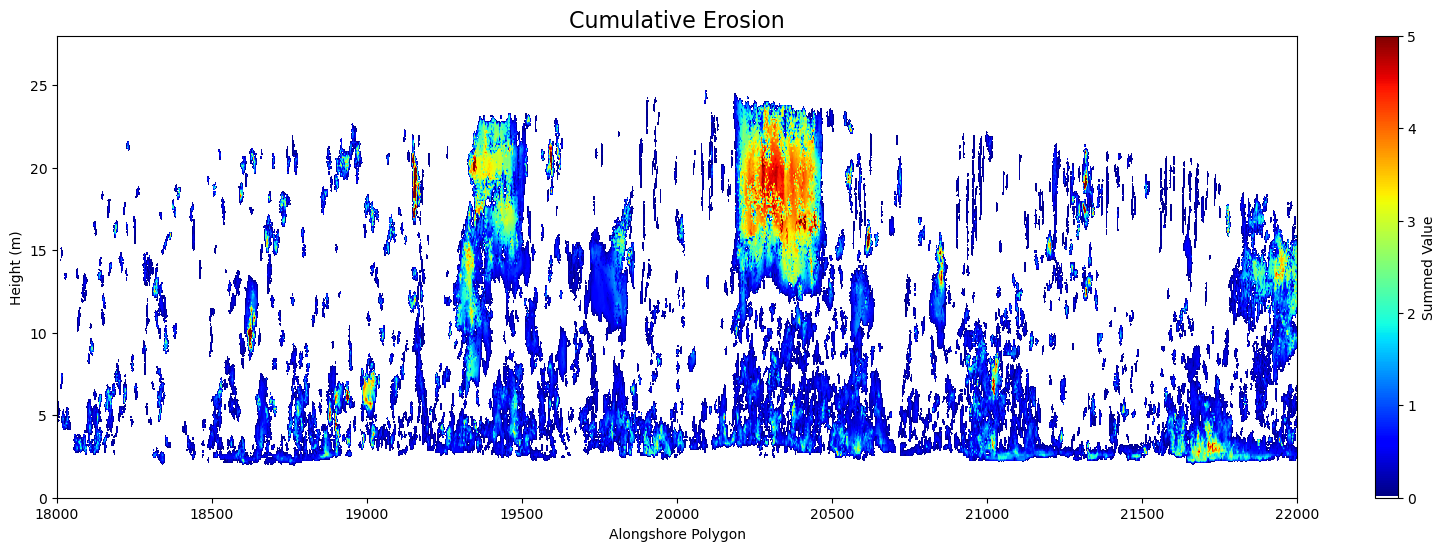

In [5]:
plot_summed_grid(grids_10x10cm, vmax=5, subset=[18000, 22000])

In [6]:
cum_erosion_curve(grids_10x10cm, grid_files_10x10cm, plotAdam=True, res=.01)


In [7]:
len(grid_files_10x10cm)

98

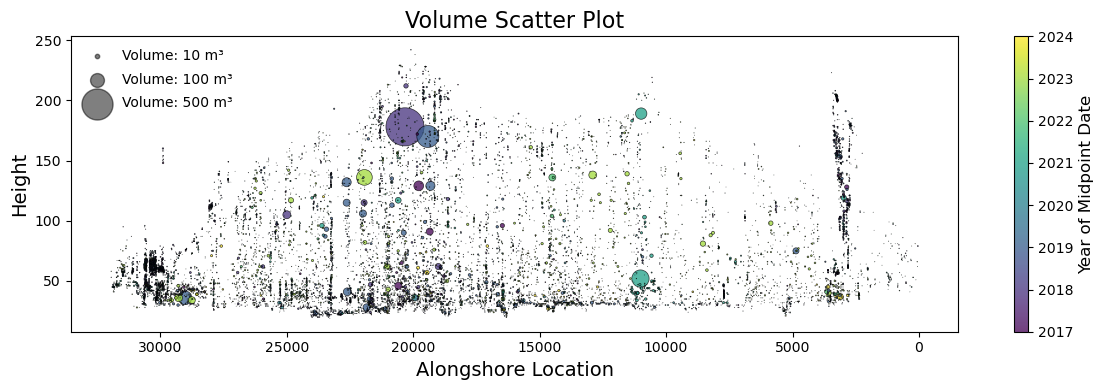

In [12]:
plot_centroid_bubbles(volume_df_10x10cm, volume_threshold=0, res=.01, plotseawalls=False)

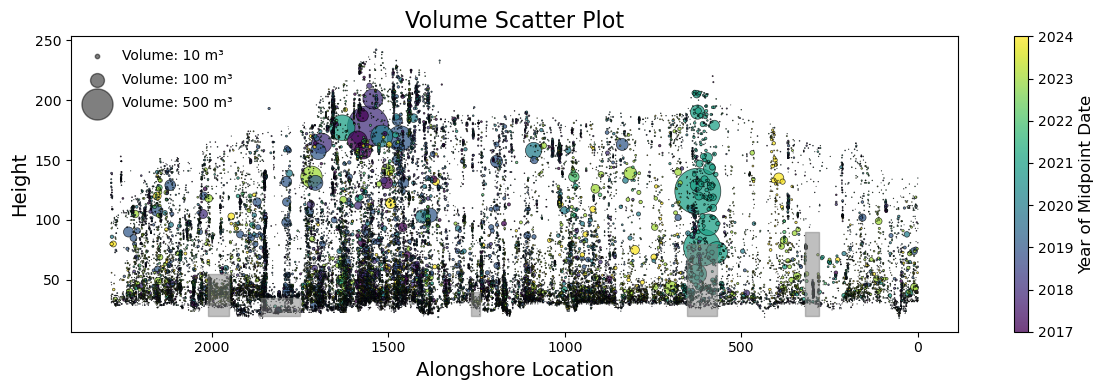

In [18]:
plot_centroid_bubbles(volume_df_10cm, volume_threshold=0, res=.01, plotseawalls=True)

In [45]:
summed_grid_gif(grids_10x10cm, grid_files_10x10cm, 4, '/Users/cjmack/Documents/Papers/Cliffs/Figures/GridFigures/cum_grid_subset10x10.gif', subset=[18000,22000], duration=0.25)

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_15103/1647862021.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


In [20]:
summed_grid_gif(grids_10x10cm, grid_files_10x10cm, 7, '/Users/cjmack/Documents/Papers/Cliffs/Figures/GridFigures/cum_grid_10x10cm.gif', duration=0.25)

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_15103/1647862021.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_59973/3252347858.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


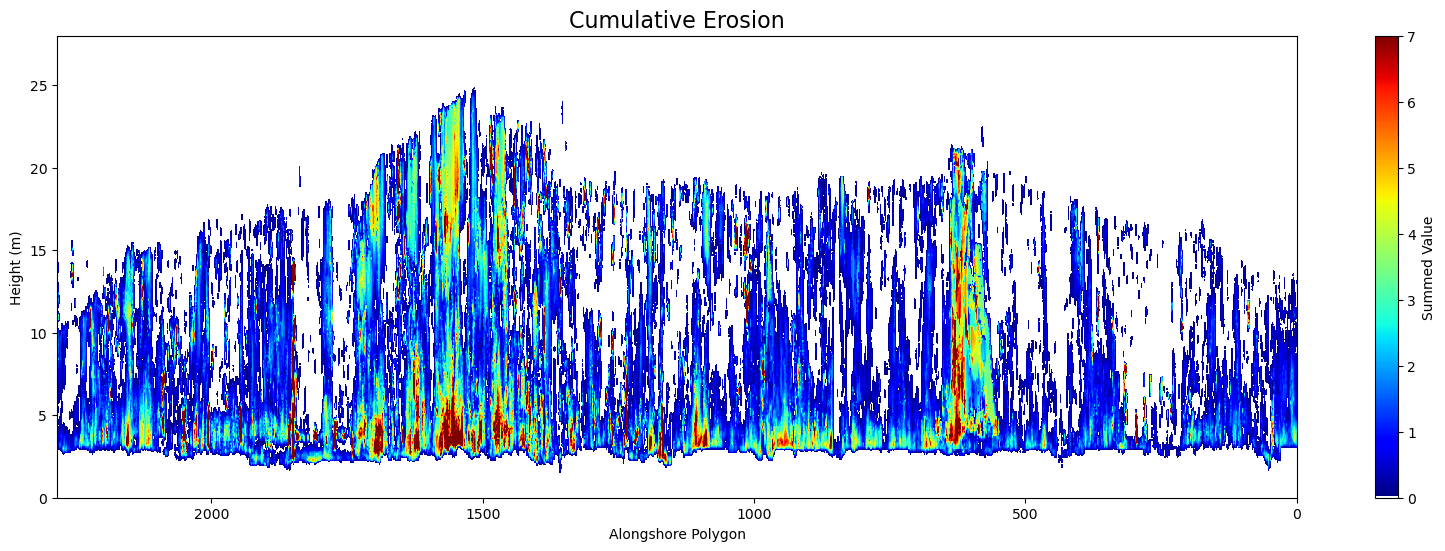

In [47]:
plot_summed_grid(grids_10cm, 7)

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_59973/2668461927.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


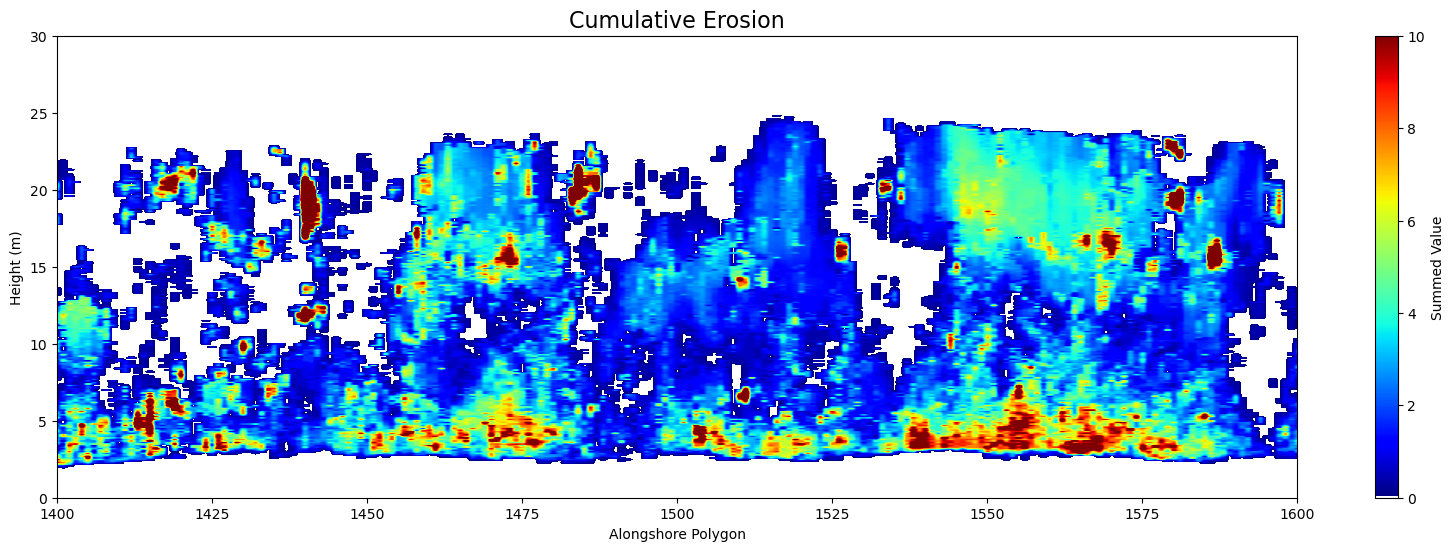

In [29]:
plot_summed_grid(grids_10cm, 10, subset=[1400, 1600])

/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_28232/1647862021.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = plt.cm.get_cmap('Reds', 256)


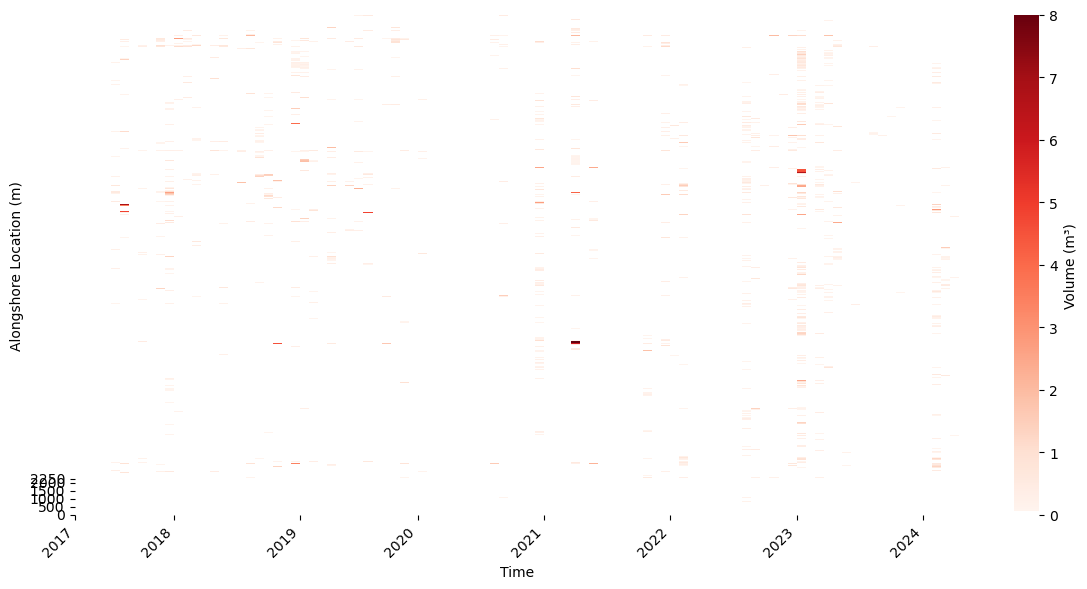

In [8]:
plot_heatmap_grid(grids_10cm, grid_files_10cm, 8, .1)

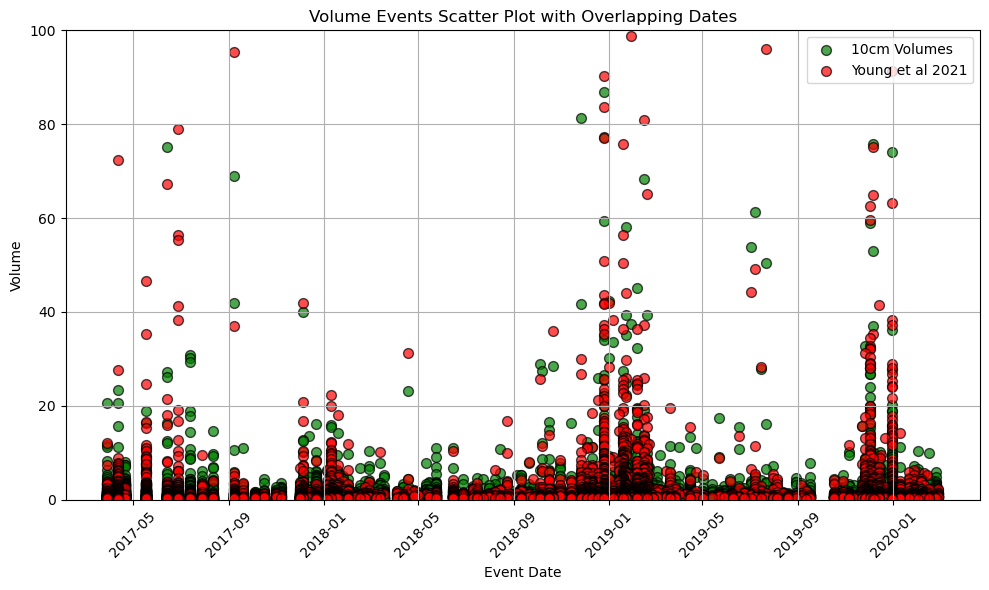

In [408]:
volume_scatter_plot(None, volume_df_10cm, plot_adam=True, ylim = 100)

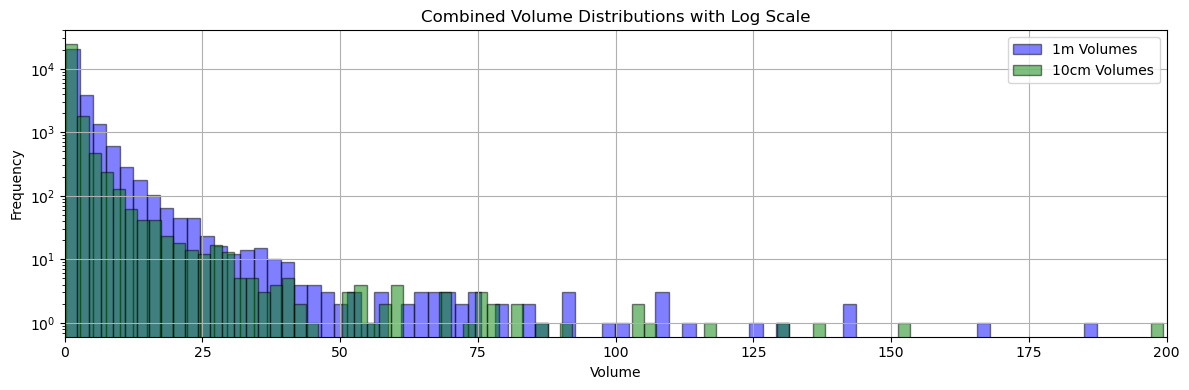

In [385]:
plot_volume_histograms(volume_df_1m, volume_df_10cm, log_scale=True, plot_adam=False)

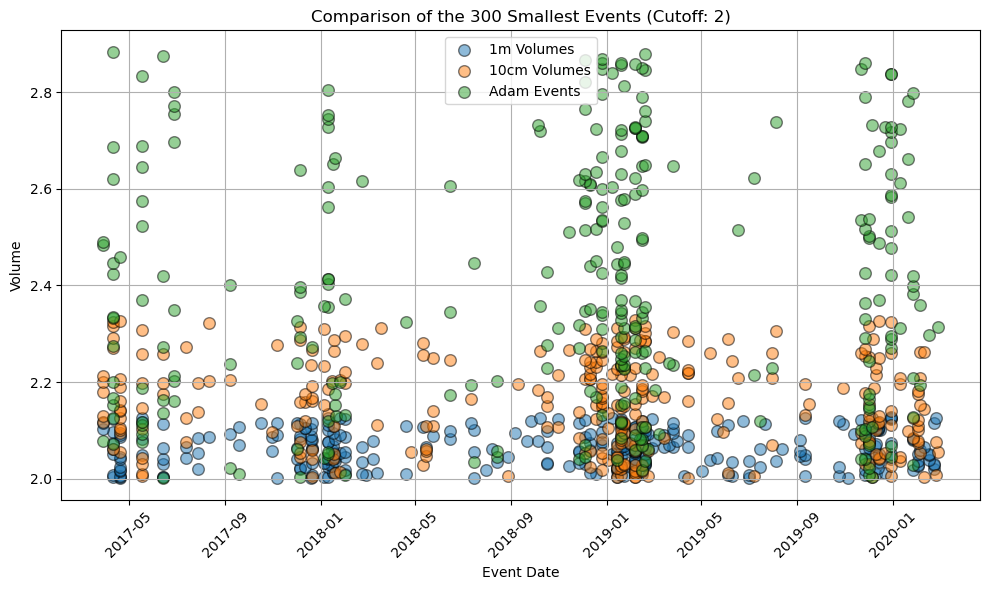

In [400]:
compare_events(volume_df_1m, volume_df_10cm, plotAdam=True, n=300, largest=False, cutoff=2)

In [345]:
volume_df_10cm

start_date   end_date midpoint_date       volume centroid_indices  \
16667 2021-05-04 2021-05-04    2021-05-04  1095.080659       (623, 124)   
4634  2018-09-26 2018-09-26    2018-09-26   872.069596      (1557, 178)   
16949 2021-08-09 2021-08-09    2021-08-09   709.392705        (611, 77)   
17734 2021-10-27 2021-10-27    2021-10-27   337.421138      (1630, 177)   
8970  2019-02-15 2019-02-15    2019-02-15   333.559207      (1466, 168)   
...          ...        ...           ...          ...              ...   
1822  2017-10-16 2017-10-16    2017-10-16     0.030570       (1384, 23)   
11224 2019-11-22 2019-11-22    2019-11-22     0.030565        (917, 30)   
9411  2019-03-15 2019-03-15    2019-03-15     0.030461       (1389, 21)   
16112 2020-12-17 2020-12-17    2020-12-17     0.030278       (1484, 38)   
9773  2019-05-13 2019-05-13    2019-05-13     0.030265       (1787, 24)   

       clusterID  
16667      147.0  
4634        36.0  
16949       18.0  
17734        0.0  
8970       208.0  
...          ...  
1822        46.0  
11224      346.0  
9411       128.0  
16112      473.0  
9773        98.0  

[26742 rows x 6 columns]

In [294]:
all_data_to_mat(grid_files_10cm, cluster_files_10cm, '/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/mat_files/all_surveys_10cm.mat')    

(array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan,

In [9]:
plot_centroid_bubbles(volume_df_10cm, volume_threshold=1, res=.1, plotseawalls=True)

NameError: name 'volume_df_10cm' is not defined

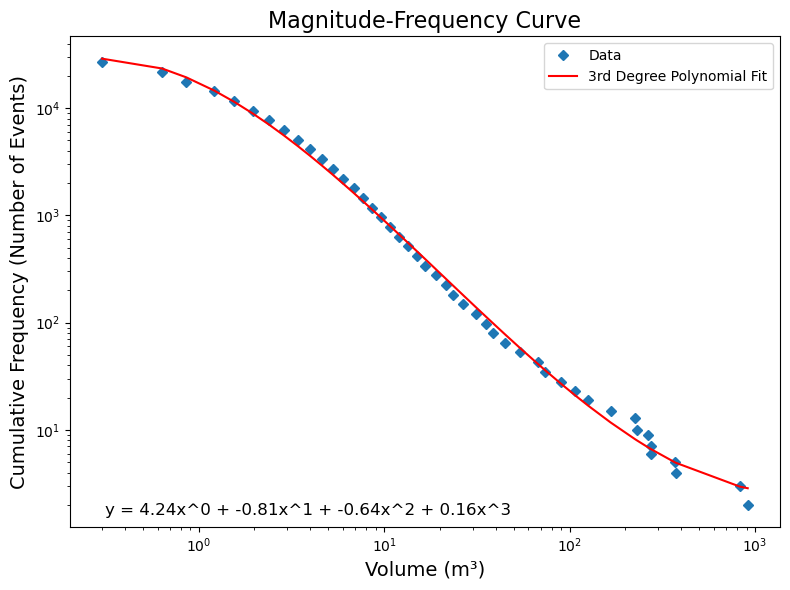

In [259]:
plot_mag_freq(volume_df_1m, degree=3)

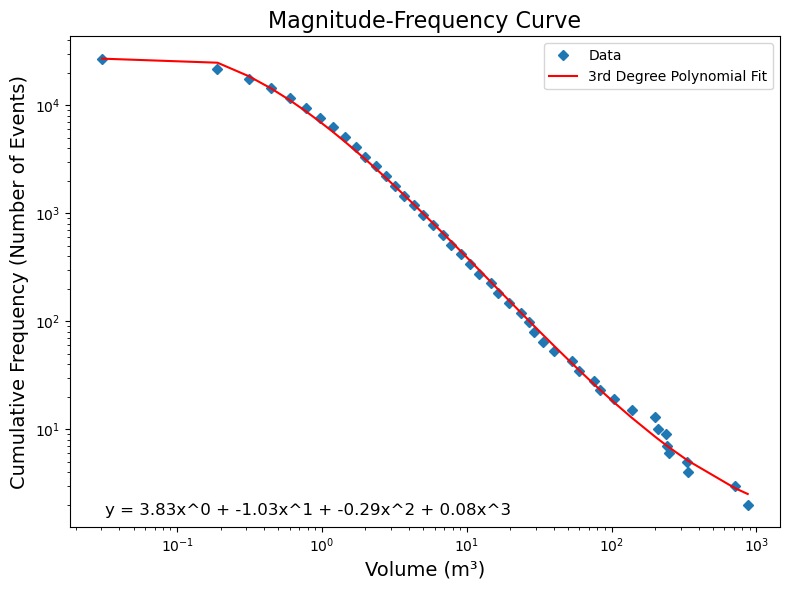

In [260]:
plot_mag_freq(volume_df_10cm, degree=3)

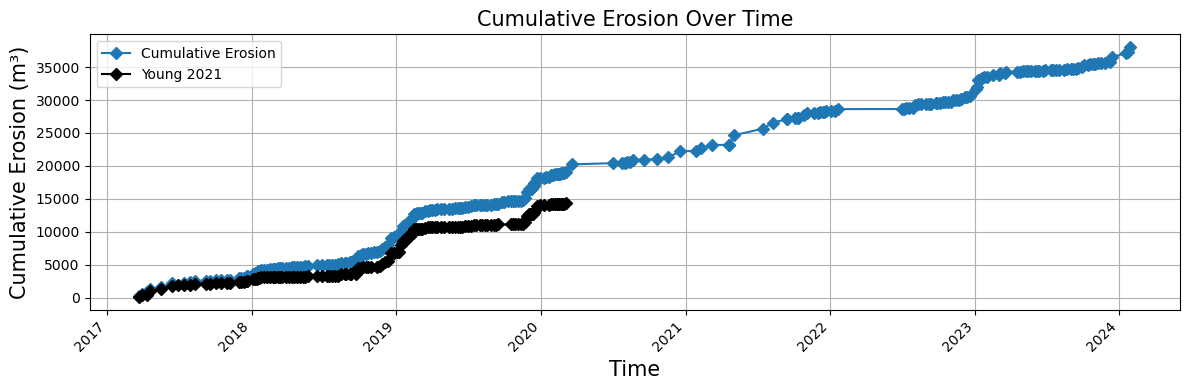

In [310]:
cum_erosion_curve(grids_10cm, grid_files_10cm, plotAdam = True, res=.1)

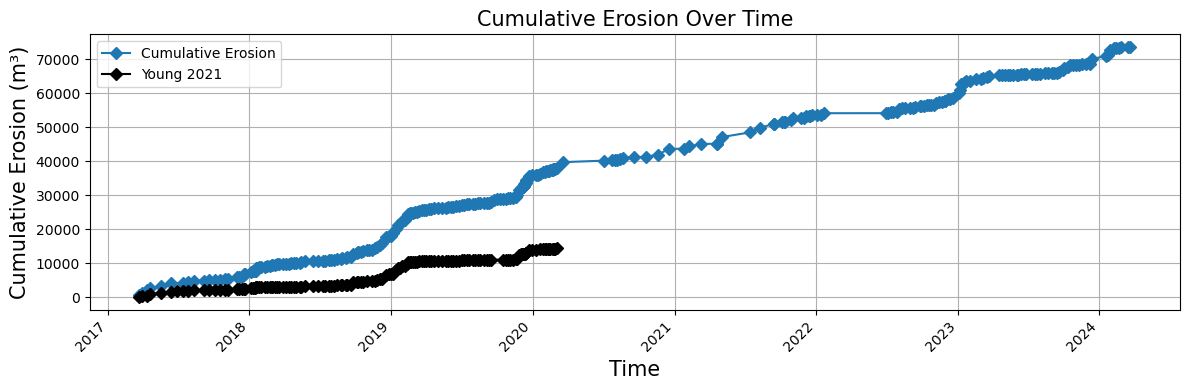

In [454]:
cum_erosion_curve(grids_1m, grid_files_1m, plotAdam = True, res=1)

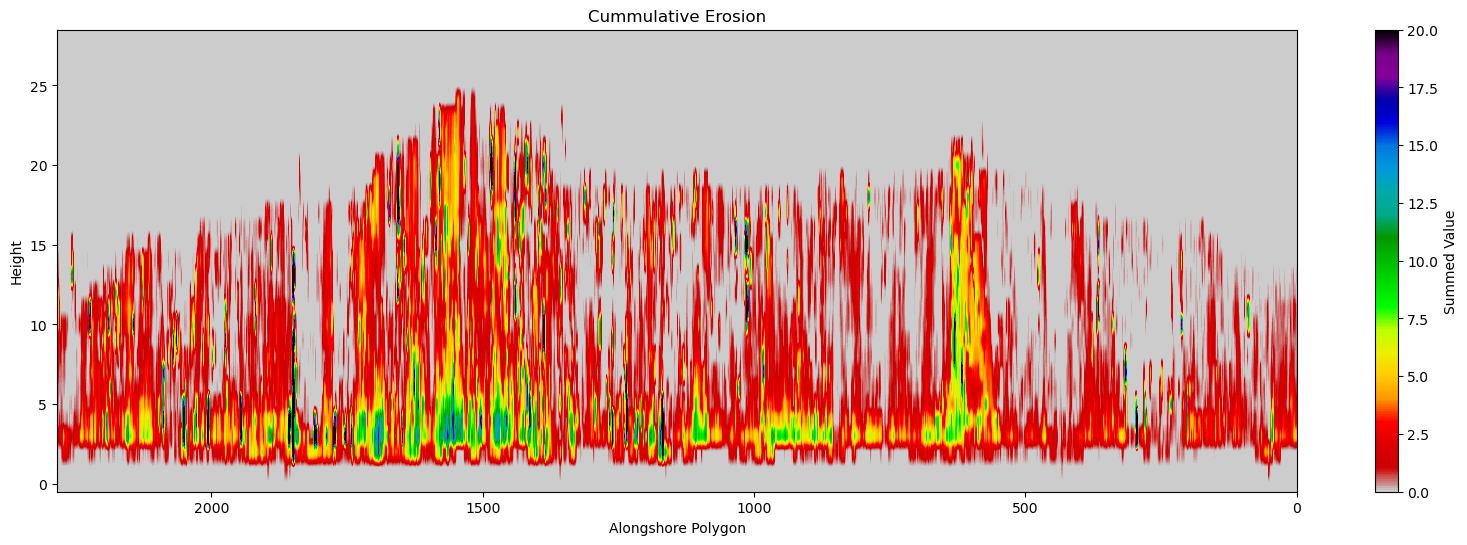

In [296]:
plot_summed_grid(grids_1m, 20)

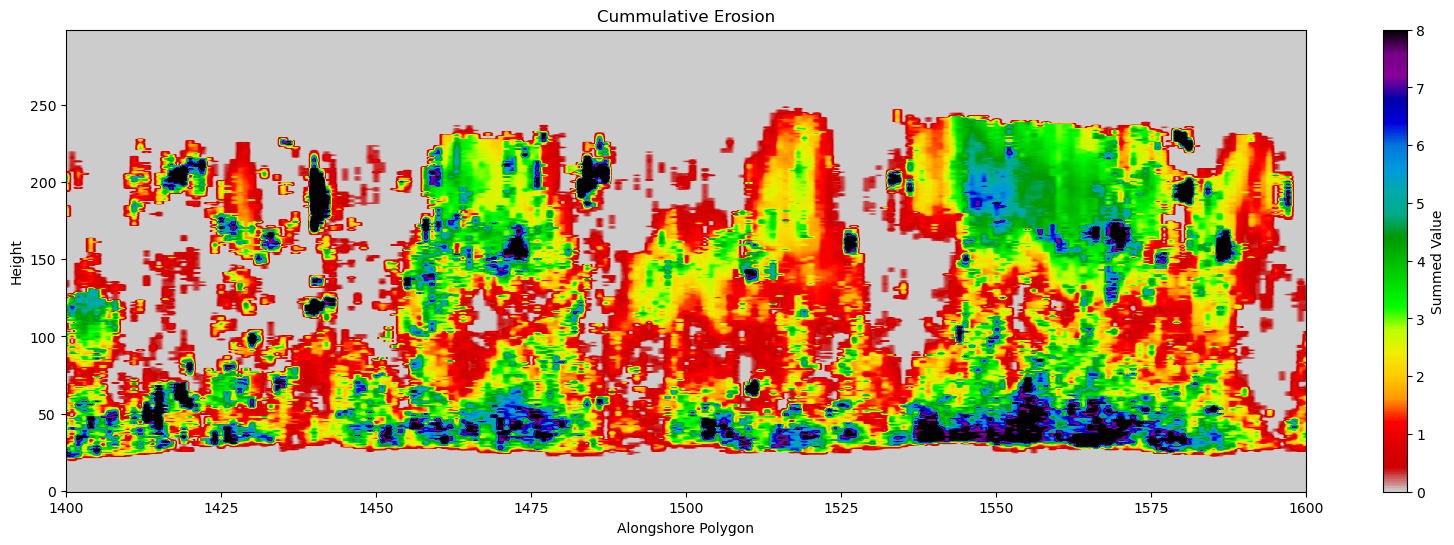

In [308]:
plot_summed_grid(grids_10cm, 8, subset=[1400, 1600])

In [311]:
plot_summed_grid(grids_10cm, 8)

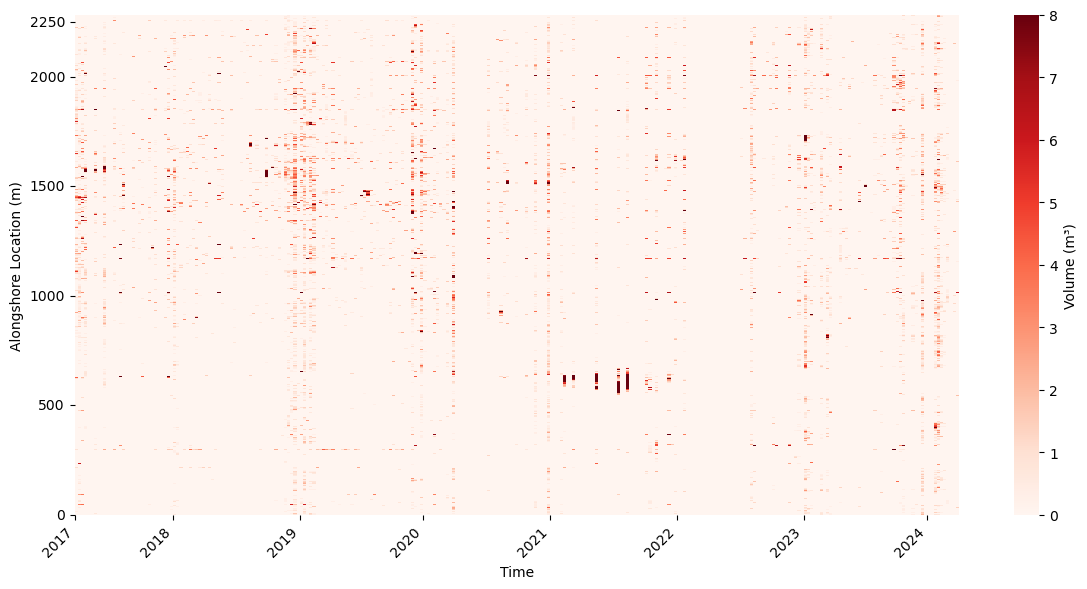

In [265]:
plot_heatmap_grid(grids_1m, grid_files_1m, 8)

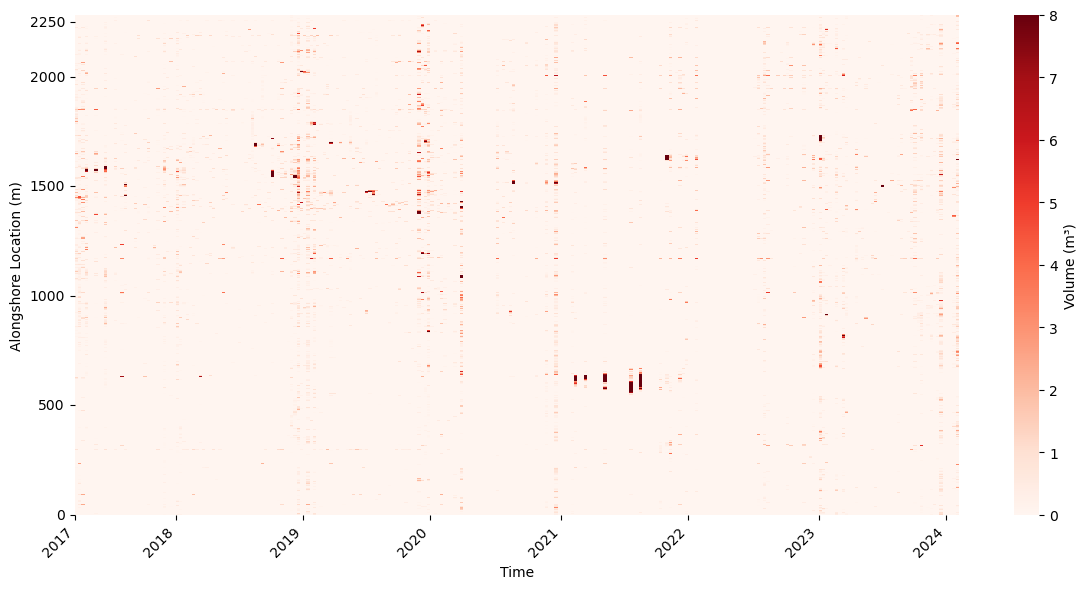

In [273]:
plot_heatmap_grid(grids_10cm, grid_files_10cm, 8, .1)

In [21]:
[vol, clu, dates, zs] = all_data_to_mat(grids, clusters, '/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/mat_files/half_timeSeries_v1.mat')

In [90]:
# Step 2: Load all CSV files into a 3D NumPy array
grid_3d_array = load_csv_to_numpy(grids)
# display(csv_files)
print(grid_3d_array.shape) 

(224, 2285, 29)


In [5]:
summed = np.nansum(grid_3d_array, axis=0)

In [ ]:
plot_summed_grid(grid_3d_array)

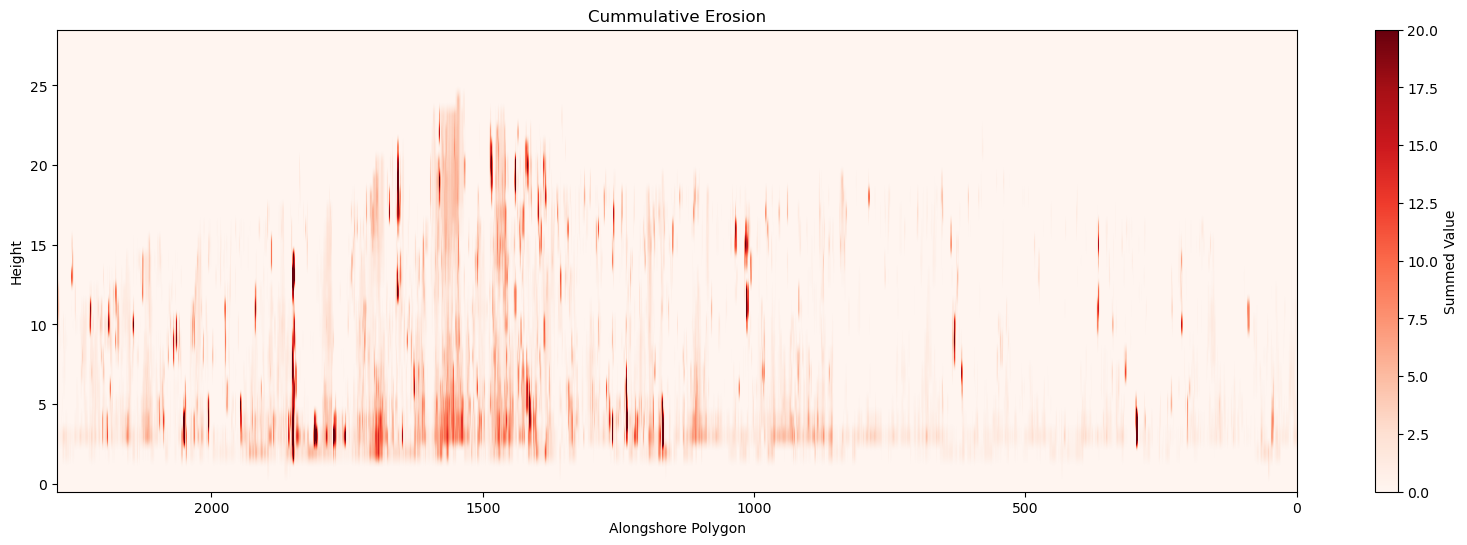

In [66]:
def plot_cumulative_gif(file_list, grid_3d_array, gif_output_path):
    """
    Create a cumulative sum GIF from a series of 2D grid data from surveys.
    
    Parameters:
    file_list (list of str): List of file paths or filenames (used for extracting dates).
    grid_3d_array (numpy.ndarray): A 3D NumPy array of shape (time_steps, n, m).
    gif_output_path (str): The path to save the output GIF file.
    """
    # Initialize a list to store the images (frames) for the GIF
    images = []
    
    # Initialize the cumulative sum array
    cumulative_grid = np.zeros_like(grid_3d_array[0], dtype=np.float64)
    
    # Regular expression to extract the date from filenames (assuming YYYYMMDD format)
    date_pattern = re.compile(r"(\d{8})")

    for i, file in enumerate(file_list):
        # Extract the date from the filename
        match = date_pattern.search(file)
        date_str = match.group(1) if match else f"Survey {i+1}"
        
        # Add the current survey to the cumulative sum
        cumulative_grid = np.nansum([cumulative_grid, grid_3d_array[i]], axis=0)

        # Transpose to switch the x and y axes
        cumulative_grid_T = cumulative_grid.T
        
        # Mask NaN values
        masked_cumulative_grid = np.ma.masked_invalid(cumulative_grid_T)
        
        # Plot the cumulative grid
        plt.figure(figsize=(20, 6))
        cmap = plt.cm.Reds
        cmap.set_bad(color='white')
        plt.imshow(masked_cumulative_grid, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax=15)
        
        # Adding labels and title with the date
        plt.colorbar(label='Summed Value')
        plt.xlabel('Alongshore Polygon')
        plt.ylabel('Height')
        plt.title(f'Cumulative Erosion - {date_str}')
        plt.gca().invert_xaxis()
        plt.xlim(1350, 1700)
        
        # Save each frame to a temporary file (to collect for the GIF)
        frame_path = f"frame_{i}.png"
        plt.savefig(frame_path)
        plt.close()
        
        # Append the frame to the images list
        images.append(imageio.imread(frame_path))
        
        # Optionally, remove the frame file after reading it into the image list
        os.remove(frame_path)
    
    # Create a GIF from the collected images
    imageio.mimsave(gif_output_path, images, format='GIF', fps=2)  # 0.5 seconds per frame

# Example call (assuming you already have file_list and grid_3d_array defined)
file_list = csv_files # Example filenames
gif_output_path = '/Users/cjmack/Documents/Papers/Cliffs/Figures/GridFigures/cumulative_erosion_v0_zoomed.gif'

# Assuming grid_3d_array is already created with the data
plot_cumulative_gif(file_list, grid_3d_array, gif_output_path)


/var/folders/wy/tbzk6rdx0_5d5y5p18xzqyfm0000gn/T/ipykernel_79794/3744715552.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(frame_path))


In [33]:
def plot_heatmap_grid(grid_3d, file_list, binsize=10):
    """
    Creates a heatmap of erosion over time (summed over bins of 10 meters) using seaborn heatmap.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D array of shape (time_steps, alongshore_length, depth).
    file_list (list of str): List of file paths or filenames (used for extracting dates).
    binsize (int): The number of alongshore meters to sum over for the heatmap.
    """
    # Display the shape for debugging if needed
    time_steps, alongshore_length, _ = grid_3d.shape

    # Regular expression to extract the date from filenames (assuming YYYYMMDD format)
    date_pattern = re.compile(r"(\d{8})")
    date_labels = []

    for i, file in enumerate(file_list):
        # Extract the date from the filename
        match = date_pattern.search(file)
        date_str = match.group(1) if match else f"Survey {i+1}"
        date_labels.append(date_str)
    
    # Sum every 10 alongshore locations (i.e., 10 rows at a time)
    binned_grid = np.add.reduceat(grid_3d, np.arange(0, alongshore_length, binsize), axis=1)

    # Create the heatmap for erosion over time using seaborn
    sum_grid = np.nansum(binned_grid, axis=2)  # Sum over depth for each time step and alongshore bin

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(sum_grid.T, cmap='Reds', cbar_kws={'label': 'Volume (m³)'}, mask=np.isnan(sum_grid.T), vmin=0, vmax=10)

    # Label axes for the heatmap
    plt.xlabel('Time')
    plt.ylabel('Alongshore Location (m)')
    plt.gca().invert_yaxis()

    
    # Set custom ticks for dates on the x-axis using the extracted date labels
    # Set X-ticks at indices corresponding to January 1st of each year
    # Convert date strings (YYYYMMDD) to datetime objects for comparison
    date_objects = [datetime.datetime.strptime(date, "%Y%m%d") for date in date_labels]

    # Generate January 1st of each year between the min and max years in date_labels
    min_year = date_objects[0].year
    max_year = date_objects[-1].year
    january_1st_dates = [datetime.datetime(year, 1, 1) for year in range(min_year, max_year + 1)]

    # Find the index in date_labels that is closest to each January 1st date
    january_1st_indices = [min(range(len(date_objects)), key=lambda i: abs(date_objects[i] - jan1)) for jan1 in january_1st_dates]

    # Set X-tick labels to display just the year for the survey closest to January 1st
    plt.xticks(january_1st_indices, [jan1.year for jan1 in january_1st_dates], rotation=45, ha="right")

    # Set Y-tick labels to 0, 500, 1000, 1500, 2000, 2250
    plt.yticks([0, 500, 1000, 1500, 2000, 2250], labels=[0, 500, 1000, 1500, 2000, 2250])


    # Show the heatmap
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming grid_3d_array is your input 3D array and file_list contains your filenames
# plot_heatmap_grid(grid_3d_array, file_list, binsize=10)


In [35]:
file_list = grids # Example filenames

plot_heatmap_grid(ten_cm, file_list, binsize=.1)


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'